# Notebook Instructions

1. If you are new to Jupyter notebooks, please go through this introductory manual <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank">here</a>.
1. Any changes made in this notebook would be lost after you close the browser window. **You can download the notebook to save your work on your PC.**
1. Before running this notebook on your local PC:<br>
i.  You need to set up a Python environment and the relevant packages on your local PC. To do so, go through the section on "**Python Installation**" in the course.<br>
ii. You need to **download the zip file available in the last unit** of this course. The zip file contains the data files and/or python modules that might be required to run this notebook.


- <i>  <span style="color:#FFFF00; background:#00C000"> <b> Please download the notebook available as downloads in the next unit. </b> It will not run in the browser.</i>
- <i> <span style="color:#00C000"> DNN models are very heavy and it is possible that your code will take time to run. Be patient and try again if required. Keep your CPU free of other burdens during the time of run! </i>

#### You will not be able to run this Notebook on the Quantra portal as some of the cells are converted to RawNB format. When running this model on your system, please convert the cells in RawNBConvert format type to Code type, using the dropdown present in the menu bar of the Jupyter Notebook. ####    

### <span style="color:brown">Notebook Objectives</span>

This notebook contains the code and explanation of a DNN model that predicts the trend of a stock. The prediction of the model is used to create a trading strategy and its returns are compared with market returns. 


### <span style="color:brown">Fetching the data</span>

In the cell below, we declare the required libraries. 

In [110]:
import numpy as np
import matplotlib.pyplot as plt
# library required for scaling the data
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import warnings
import yfinance as yf
warnings.filterwarnings('ignore')

In [111]:
data = pd.read_csv('../data_modules/SBIN.csv', index_col=0,
                   parse_dates=True, na_values=0).dropna()

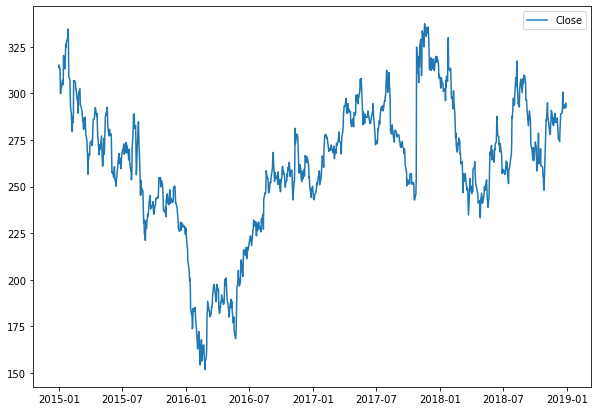

In [112]:
plt.figure(figsize=(10, 7))
plt.plot(data.Close)
plt.legend(['Close'])
plt.show()

### <span style="color:brown">Scaling the data</span>

Our input data or features consists of Open, Low, High & Close (OHLC) prices and Volume. The prices and the volume would be scaled in different fashions. 

The in-built function MinMaxScaler, available in sklearn, is used to scale the Volume column. It can't be used to scale the prices columns, because it scales each column individually and ignores the relationship between them. We want to retain the dependency between High >= Close >= Low, so will scale these columns without the function. 

#### <span style="color:#ac6600">Scaling the prices (OHLC)</span>

- Find the minimum and maximum values of all OHLC prices in the entire data set.
- Scale up the OHLC columns accordingly so that the resultant values are between 0-1.

These two steps are carried in the next two cells. 

In [113]:
# Specify the test data size
test_size = 200

# To avoid any look forward bias we will be taking only the train data to scale the data
# Using .max() once gives the maximum values of each column
max_ = data.iloc[:-test_size][['Open', 'High', 'Low', 'Close']].max().max()
min_ = data.iloc[:-test_size][['Open', 'High', 'Low', 'Close']].min().min()
max_, min_

(351.3, 148.25)

In [114]:
X1 = (data[['Open', 'High', 'Low', 'Close']]-min_)/(max_-min_)
X1 = np.array(X1)

#### <span style="color:#ac6600">Scaling the volume</span>

The scaler function that we have used below is an in-built function in sklearn that exactly performs the same scaling technique that we used on the OHLC data. Here we have used this MinMaxScaler to scale the Volume column.

In [115]:
# Here we will instantiate a Minmaxscaler function
# Then fit the Volume column data and transform it to the range of 0,1.
# Here we specify the shape of input as it is a single column, and sklearn expexcts you to explicyt
# reshape when input data is a single column
scl = MinMaxScaler()
scl.fit(data[['Volume']].iloc[:-test_size].values.reshape(-1, 1))
X2 = scl.transform(data[['Volume']].values.reshape(-1, 1))

Now, we will reassign the computed values back into the data and print it to see the changes

In [116]:
data = data.assign(Open=X1[:, 0])
data = data.assign(High=X1[:, 1])
data = data.assign(Low=X1[:, 2])
data = data.assign(Close=X1[:, 3])
data = data.assign(Volume=X2[:, 0])
data.tail()

,Close,High,Low,Open,Volume,Last
Date,,,,,,
2018-12-21 00:00:00+00:00,0.707461,0.730116,0.702044,0.716080,0.052628,291.90
2018-12-24 00:00:00+00:00,0.713125,0.722728,0.698843,0.715341,0.038322,293.05
2018-12-26 00:00:00+00:00,0.718542,0.722728,0.684068,0.712140,0.040760,294.15
2018-12-27 00:00:00+00:00,0.708692,0.735533,0.705491,0.731101,0.050814,292.15
2018-12-28 00:00:00+00:00,0.721743,0.733071,0.715587,0.715834,0.041497,294.80


#### <span style="color:#ac6600">Check out the updated columns</span>

You can see that the OHLCV values have been updated in the table above and they are all within the range 0-1.

### <span style="color:brown">Creating feature and target datasets</span>

Now, we will create prediction data 'Y' and split test/training sets. 

The steps are: 

- Step 1: Create a feature data set (OHLCV) called <font color =red>X</font> which will be used to create the input for the DNN model.
- Step 2: Create a dataset called <font color =red>y</font> that contains the future price trend.
- Step 3: Split the dataset so that the last 200 rows are test data. 


In [117]:
# Step 1: Creation of Dataset X
X = data[['Open', 'High', 'Low', 'Close', 'Volume']]

In [118]:
# Step 2: Creation of Dataset y
# Here we first create a column of ones that has the same length as the dataframe 'data'.
# Later we will store the target values in this column.
# We have given the target of predicting the weekly returns' trend to our strategy.
# So the target variable will attempt to predict if the close price has increased or decreased after 5 trading days.
y = np.ones(len(data.Close))

# If the returns are higher, then 'y' is 1, else '0'.
y = np.where(data.Close > data.Close.shift(5), 1, 0)

In [119]:
# Step 3: Creation of 4 Datasets
X_train = np.array(X.iloc[5:-test_size])
y_train = np.array(y[5:-test_size])
X_test = np.array(X.iloc[-test_size:])
y_test = np.array(y[-test_size:])

Note that the value of 'y' is only 0 or 1. These are called 'Classes' or categories. If one class is more than the other class then the model will end up learning more instances of one, and may predict only that class correctly. To counter this, we will set weights to both the classes which will enforce the model to give different learning weightage to different classes, making the net weight of all classes equal.

### <span style="color:brown">Set Class Weights</span>

The steps are:
- Calculate the number of instances of each class (#s of '0's and '1's).
- Calculate the percentage distribution of each class in the train data (% of '0's and '1's).
- Allocate the percentage distribution of class 0 to class 1 and vice versa (this is explained in a previous video).

This allows the model to pick data of both the classes or cases, when the output(y) is '0' or '1', with equal probability. Hence, the model should learn well. 

In [91]:
class_1 = y_train.sum()
class_0 = len(y_train)-class_1

class_1, class_0

(381, 400)

Here we will calculate the percentage of each of the classes in the training dataset.
Once this is done, we allocate the percentage allocation of Class 0 to be equal to the percentage of Class 1 labels in the train data.
The purpose of doing this is to give equal importance to both classes.

In [92]:
class_0_percentage = class_0/len(y_train)
class_1_percentage = class_1/len(y_train)

class_0_weight = class_1_percentage
class_1_weight = class_0_percentage

# We will create a dictionary called class_weight to allocate the corresponding weights to each of the labels.
class_weight = {0: class_0_weight, 1: class_1_weight}

And that concludes data pre-processing steps! You are doing great!!! 

### <span style="color:brown">Creating the DNN model</span>

We have three code cells here, which

- Import the libraries.
- Define the hyperparameters.
- Create the model sequentially, layer by layer.


#### Please change the below cell to a code type to run it.

In [93]:
# Libraries
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Dense, Activation, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

Did you see this error? 
ModuleNotFoundError: No module named 'tensorflow'

If yes, then <span style="color:#ac6600">please install tensorflow!</span> If not, then please ignore! 

In [94]:
# Parameters - please tweak them in later runs
dropout_ratio = 0.23
momentum = 0.99
np.random.seed(42)
neurons = 175
act_1 = 'tanh'
act_2 = 'softmax'

Before we create the model, let us understand the code for the first layer.

*model.add(Dense(neurons, use_bias=True, kernel_initializer='he_normal',bias_initializer='zeros',input_shape=X_train.shape[1:]))*

- Dense: to define a dense layer.
- neurons: to define the number of neurons (this keeps on increasing in every layer).
- use_bias=True: it keeps the bias term in the equation.
- kernel_initializer='he_normal': at the first run, use weights from He-normal distribution.
- bias_initializer='zeros': at the first run, use bias as '0'.
- input_shape=X_train.shape[1:])): to define the number of columns or features that go as input in the first run.

It is not difficult to understand the code for other layers now! 


#### Please change the below cell to a code type to run it.

In [95]:
model=Sequential()
model.add(Dense(neurons, kernel_initializer='he_normal',input_shape=(5,), bias_initializer='zeros'))
model.add(Activation(act_1))
model.add(Dropout(dropout_ratio))

model.add(Dense(neurons*2, use_bias=True, kernel_initializer='he_normal'
               , bias_initializer='zeros'))
model.add(Activation(act_1))
model.add(Dropout(dropout_ratio))
model.add(Dense(neurons*3, use_bias=True, kernel_initializer='he_normal'
              , bias_initializer='zeros'))
model.add(Activation(act_1))
model.add(Dropout(dropout_ratio))
model.add(Dense(neurons*4, use_bias=True, kernel_initializer='he_normal'
             , bias_initializer='zeros'))
model.add(Activation(act_1))
model.add(Dropout(dropout_ratio))
model.add(Dense(neurons*5, use_bias=True, kernel_initializer='he_normal'
             , bias_initializer='zeros'))
model.add(Activation(act_1))
model.add(Dropout(dropout_ratio))

model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

### <span style="color:brown">Define and save the monitoring parameter</span>

In Keras, we can save the best weights of the model by creating a checkpoint during the training of the model. To create a checkpoint, we specify the metric that needs to be monitored and saved accordingly.  

<span style="color:#ac6600">Validation set loss</span> is passed as the monitoring parameter. The mode of saving is specified as 'auto'. This means that the model will save the weights of the network whenever a low value for the validation loss is generated. 

The file path is weights-best2.hdf5 to save the weights of the model.

The verbose=1 parameter defines how much information about every batch training needs to be printed.

#### Please change the below cell to a code type to run it.

In [96]:
filepath = 'weights-best2.hdf5'

checkpoint = ModelCheckpoint(
    filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [97]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 175)               1050      
                                                                 
 activation_15 (Activation)  (None, 175)               0         
                                                                 
 dropout_15 (Dropout)        (None, 175)               0         
                                                                 
 dense_19 (Dense)            (None, 350)               61600     
                                                                 
 activation_16 (Activation)  (None, 350)               0         
                                                                 
 dropout_16 (Dropout)        (None, 350)               0         
                                                                 
 dense_20 (Dense)            (None, 525)              

### <span style="color:brown">Training the model</span>


Now, it's time to train the model.

The callback feature in the code below saves the best weights. 

#### Please change the below cell to a code type to run it.

In [98]:
training = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, validation_split=0.2,
                     callbacks=[checkpoint], class_weight=class_weight)

Epoch 1/100
19/20 [===========================>..] - ETA: 0s - loss: 0.4719 - accuracy: 0.5362
Epoch 1: val_loss improved from inf to 0.67883, saving model to weights-best2.hdf5
20/20 [==============================] - 1s 22ms/step - loss: 0.4735 - accuracy: 0.5385 - val_loss: 0.6788 - val_accuracy: 0.6178
Epoch 2/100
18/20 [==========================>...] - ETA: 0s - loss: 0.4652 - accuracy: 0.5087
Epoch 2: val_loss improved from 0.67883 to 0.67616, saving model to weights-best2.hdf5
20/20 [==============================] - 0s 17ms/step - loss: 0.4624 - accuracy: 0.5032 - val_loss: 0.6762 - val_accuracy: 0.6178
Epoch 3/100
20/20 [==============================] - ETA: 0s - loss: 0.3886 - accuracy: 0.5064
Epoch 3: val_loss did not improve from 0.67616
20/20 [==============================] - 0s 14ms/step - loss: 0.3886 - accuracy: 0.5064 - val_loss: 0.8228 - val_accuracy: 0.3822
Epoch 4/100
19/20 [===========================>..] - ETA: 0s - loss: 0.3897 - accuracy: 0.5181
Epoch 4: val_

Epoch 31/100
16/20 [=======================>......] - ETA: 0s - loss: 0.3725 - accuracy: 0.5469
Epoch 31: val_loss improved from 0.66577 to 0.65848, saving model to weights-best2.hdf5
20/20 [==============================] - 0s 14ms/step - loss: 0.3734 - accuracy: 0.5304 - val_loss: 0.6585 - val_accuracy: 0.6242
Epoch 32/100
16/20 [=======================>......] - ETA: 0s - loss: 0.3694 - accuracy: 0.5254
Epoch 32: val_loss did not improve from 0.65848
20/20 [==============================] - 0s 12ms/step - loss: 0.3689 - accuracy: 0.5160 - val_loss: 0.8229 - val_accuracy: 0.3822
Epoch 33/100
17/20 [========================>.....] - ETA: 0s - loss: 0.3876 - accuracy: 0.4743
Epoch 33: val_loss did not improve from 0.65848
20/20 [==============================] - 0s 17ms/step - loss: 0.3893 - accuracy: 0.4728 - val_loss: 0.6641 - val_accuracy: 0.6178
Epoch 34/100
18/20 [==========================>...] - ETA: 0s - loss: 0.3914 - accuracy: 0.4913
Epoch 34: val_loss did not improve from 0.

20/20 [==============================] - ETA: 0s - loss: 0.3504 - accuracy: 0.5609
Epoch 60: val_loss did not improve from 0.62587
20/20 [==============================] - 0s 13ms/step - loss: 0.3504 - accuracy: 0.5609 - val_loss: 0.6946 - val_accuracy: 0.3949
Epoch 61/100
16/20 [=======================>......] - ETA: 0s - loss: 0.3449 - accuracy: 0.5449
Epoch 61: val_loss did not improve from 0.62587
20/20 [==============================] - 0s 13ms/step - loss: 0.3470 - accuracy: 0.5433 - val_loss: 0.6746 - val_accuracy: 0.5860
Epoch 62/100
16/20 [=======================>......] - ETA: 0s - loss: 0.3368 - accuracy: 0.5742
Epoch 62: val_loss did not improve from 0.62587
20/20 [==============================] - 0s 13ms/step - loss: 0.3385 - accuracy: 0.5689 - val_loss: 0.6459 - val_accuracy: 0.6624
Epoch 63/100
16/20 [=======================>......] - ETA: 0s - loss: 0.3477 - accuracy: 0.5684
Epoch 63: val_loss did not improve from 0.62587
20/20 [==============================] - 0s 12m

Epoch 90/100
16/20 [=======================>......] - ETA: 0s - loss: 0.3293 - accuracy: 0.6074
Epoch 90: val_loss did not improve from 0.61332
20/20 [==============================] - 0s 12ms/step - loss: 0.3250 - accuracy: 0.6266 - val_loss: 0.7096 - val_accuracy: 0.5478
Epoch 91/100
16/20 [=======================>......] - ETA: 0s - loss: 0.3232 - accuracy: 0.6035
Epoch 91: val_loss did not improve from 0.61332
20/20 [==============================] - 0s 12ms/step - loss: 0.3188 - accuracy: 0.6106 - val_loss: 0.6283 - val_accuracy: 0.6879
Epoch 92/100
16/20 [=======================>......] - ETA: 0s - loss: 0.3281 - accuracy: 0.6191
Epoch 92: val_loss did not improve from 0.61332
20/20 [==============================] - 0s 12ms/step - loss: 0.3267 - accuracy: 0.6218 - val_loss: 0.6770 - val_accuracy: 0.6051
Epoch 93/100
16/20 [=======================>......] - ETA: 0s - loss: 0.3164 - accuracy: 0.6113
Epoch 93: val_loss did not improve from 0.61332
20/20 [===========================

 These best weights are loaded into the model using the load_weights function.

model.load_weights("weights-best2.hdf5")

Let us see what features are available for a fit object. Here we can see that there are four values that we can access:

- val_acc 
- val_loss 
- loss - we use this 
- acc

Let us plot the loss values to see how the training and validation losses have converged.

If you change the parameters and train the model again for a different data set, then try to check this plot. It will help you in understanding if the model is overfitting or underfitting the train data. 

In [99]:
training.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

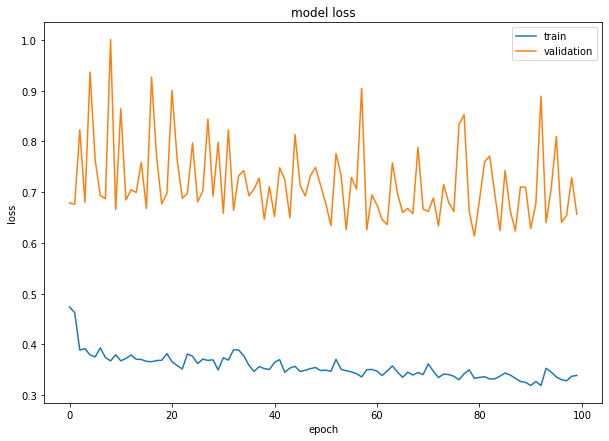

In [100]:
# summarize history for loss
plt.figure(figsize=(10, 7))
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

## Predicting the Trend

Now, we will create a list called predict_close that would hold the DNN model's predictons on the test data.

The output of the keras predict function is a probability value, where a probability of more than 0.5 means that the data belongs to class 1 and a probability of less than or equal to 0.5 means that the data belongs to class 0.

Based on these probability values, we will separate the Buy and Sell signals for the strategy, by assuming a buy signal of +1 when the output probability is more than 0.5 and a sell signal of 0 otherwise.

In [101]:
from sklearn.metrics import accuracy_score
predict_trend = np.ones(len(X_test))
for i in range(X_test.shape[0]):
    predict_trend[i] = np.where(model.predict(
        np.expand_dims(X_test[i], axis=0))[0][0] > 0.5, 1, 0)
predict_trend = np.reshape(predict_trend, (1, -1)).tolist()[0]

acc = accuracy_score(list(y_test), list(predict_trend))

### The results might vary due to the Dropout layer and the changes in data if any.

In [102]:
print("The Accuracy of the model on the test set is:", acc*100, '%')
print("\n\n\nThe Signals Predicted\n", list(predict_trend),sum(predict_trend))

The Accuracy of the model on the test set is: 65.5 %



The Signals Predicted
 [1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 

## Visualizing and comparing the performance

Now, let us plot the performance of the model on the test data by multiplying the buy and sell signals with the corresponding future returns.

Once we calculate the percentage returns of the model, we will take a cumulative sum of all these returns on the test data to measure the overall performance of the model.


We have also plotted the cumulative markets returns to compare how a simple Buy and Hold strategy would have performed in comparison to our model.

The annualized interest rate in India is currently 5%. So, for the 100-day period in the test data, the interest rate would be adjusted.

In [103]:
market_returns = pd.Series(
    data.Close.shift(-1).iloc[-test_size:].pct_change().values)
strategy_returns = pd.Series(predict_trend*market_returns)
excess_return= strategy_returns - 0.05/252

The below function returns the Sharpe ratio for the excess returns (Strategy returns - Risk free rate) passed to it.

In [105]:
def annualized_sharpe_ratio(returns, N=252):
    return np.sqrt(N) * returns.mean() / returns.std()

### The results might vary due to the Dropout layer and the changes in data if any.

In [106]:
sharpe_test = annualized_sharpe_ratio(excess_return)
print(sharpe_test)

0.7280561464046301


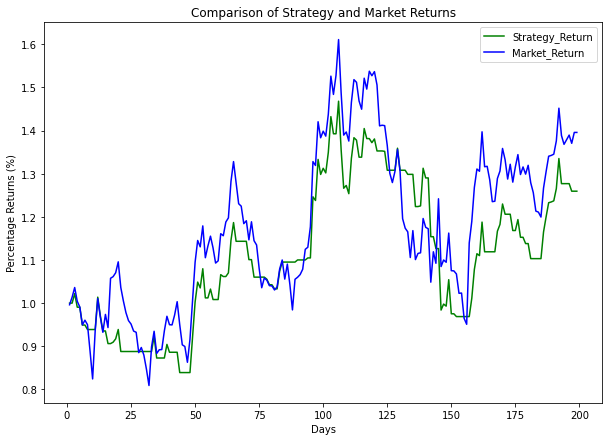

In [107]:
plt.figure(figsize=(10, 7))
plt.title('Comparison of Strategy and Market Returns')
plt.plot((strategy_returns+1).cumprod(), c='g')
plt.plot((market_returns+1).cumprod(), c='b')
plt.ylabel('Percentage Returns (%)')
plt.xlabel('Days')
plt.legend(['Strategy_Return', 'Market_Return'])
plt.show()

# Calculate the Final Returns
The final return obtained from a certain strategy is calculated as the cumulative product of (strategy return +1).

.cumprod() - Gives the cumulative product of a series.

In [108]:
final_return = (strategy_returns+1).cumprod()

### Saving the model for later usage

##### Once you have created a model that you want to save, you can save the model in a json format and use it later.

In [ ]:
# Serialize the model to JSON
# to_json() is an inbuilt function of Keras models
model_json = model.to_json()
# Write this model to a ".json" file
with open('model.json', "w") as json_file:
    json_file.write(model_json)
# Serialize the weights of neurons to HDF5
model.save_weights('model.h5')
print("Saved model to disk")

##### Whenever you want to load this saved model, you can use the model_from_json function from keras with the following code:

In [ ]:
# Use the model_from_json function to load the previously saved model
from keras.models import model_from_json
# Load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# Load weights of neurons for the model
loaded_model.load_weights('model.h5')
print("Loaded model from disk")

### Conclusion

In the past 100 days, the model has returned (%)

In [109]:
final_return.tail(1)

199    1.259491
dtype: float64

####  Please note: We have given a simple classifier model that could be used for paper trading. This is just a toy example, and not meant for real trading. To build a more robust classification model, we need to perform a thorough satistical analysis on multiple data sets and time frames.